In [1]:
!nvidia-smi

Sun Aug  8 17:12:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
!pip install vit-pytorch linformer

In [2]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt   
from linformer import Linformer   
import glob   
from PIL import Image
from itertools import chain   
from vit_pytorch.efficient import ViT   
from tqdm.notebook import tqdm   
from __future__ import print_function
import torch   
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms   
from torch.optim.lr_scheduler import StepLR   
from torch.utils.data import DataLoader, Dataset
import zipfile  
from sklearn.model_selection import train_test_split 
import collections.abc

In [6]:
# Mounting the drive and copying the code from github to drive...anilaknb@gmail.com

from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [27]:
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 

In [8]:
!unzip -q "/content/gdrive/MyDrive/EVA6_P1_S13_VIT/train.zip"
!ls

gdrive	sample_data  train


In [3]:
train_dir = '/content/train'

train_list = glob.glob(os.path.join(train_dir,'*.jpg'))

In [4]:
print(f"Train Data: {len(train_list)}")

Train Data: 25000


In [5]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

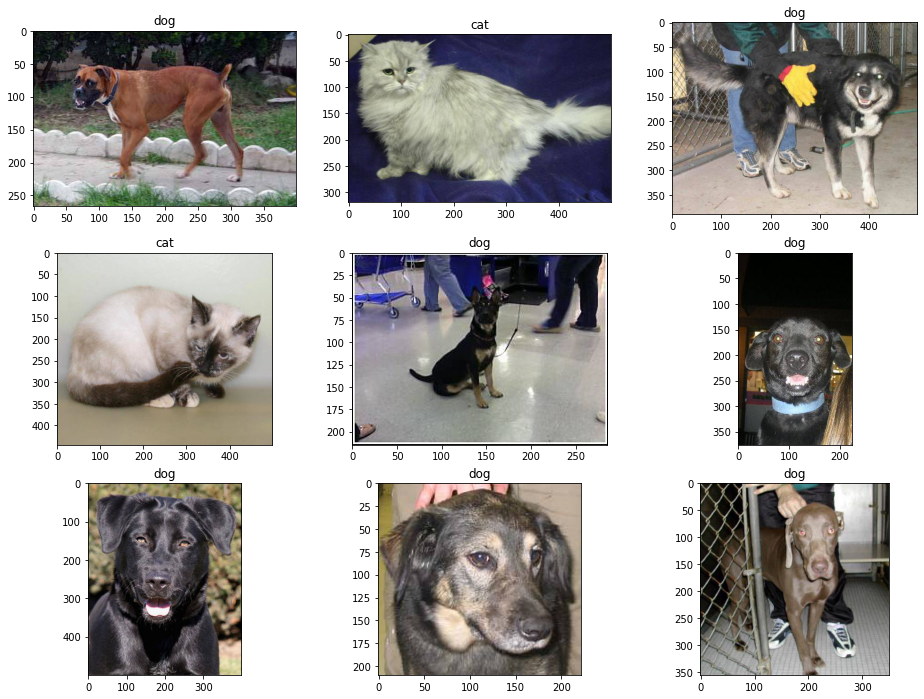

In [6]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [7]:
import random
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=random.seed(2))
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")

Train Data: 20000
Validation Data: 5000


In [8]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [9]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0
        return img_transformed, label

In [10]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=val_transforms)

In [19]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)

# **Pretrained VIT model and linformer**

Source : https://analyticsindiamag.com/hands-on-vision-transformers-with-pytorch/

In [20]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [22]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [23]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=2,
    transformer=efficient_transformer,
    channels=3,
).to(device)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [28]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


Epoch : 1 - loss : 0.6859 - acc: 0.5477 - val_loss : 0.6773 - val_acc: 0.5736




Epoch : 2 - loss : 0.6802 - acc: 0.5659 - val_loss : 0.6730 - val_acc: 0.5785




Epoch : 3 - loss : 0.6724 - acc: 0.5803 - val_loss : 0.6656 - val_acc: 0.5876




Epoch : 4 - loss : 0.6686 - acc: 0.5832 - val_loss : 0.6619 - val_acc: 0.5999




Epoch : 5 - loss : 0.6597 - acc: 0.6003 - val_loss : 0.6573 - val_acc: 0.6088




Epoch : 6 - loss : 0.6506 - acc: 0.6117 - val_loss : 0.6449 - val_acc: 0.6167




Epoch : 7 - loss : 0.6479 - acc: 0.6126 - val_loss : 0.6413 - val_acc: 0.6206




Epoch : 8 - loss : 0.6391 - acc: 0.6252 - val_loss : 0.6448 - val_acc: 0.6307




Epoch : 9 - loss : 0.6353 - acc: 0.6336 - val_loss : 0.6291 - val_acc: 0.6373




Epoch : 10 - loss : 0.6252 - acc: 0.6406 - val_loss : 0.6256 - val_acc: 0.6386




Epoch : 11 - loss : 0.6218 - acc: 0.6448 - val_loss : 0.6141 - val_acc: 0.6572




Epoch : 12 - loss : 0.6155 - acc: 0.6530 - val_loss : 0.6101 - val_acc: 0.6604




Epoch : 13 - loss : 0.6108 - acc: 0.6555 - val_loss : 0.6164 - val_acc: 0.6491




Epoch : 14 - loss : 0.6053 - acc: 0.6649 - val_loss : 0.6223 - val_acc: 0.6523




Epoch : 15 - loss : 0.5992 - acc: 0.6708 - val_loss : 0.6125 - val_acc: 0.6616




Epoch : 16 - loss : 0.5947 - acc: 0.6726 - val_loss : 0.6196 - val_acc: 0.6505




Epoch : 17 - loss : 0.5923 - acc: 0.6795 - val_loss : 0.6005 - val_acc: 0.6756




Epoch : 18 - loss : 0.5918 - acc: 0.6754 - val_loss : 0.5907 - val_acc: 0.6891




Epoch : 19 - loss : 0.5903 - acc: 0.6821 - val_loss : 0.5906 - val_acc: 0.6875




Epoch : 20 - loss : 0.5895 - acc: 0.6801 - val_loss : 0.5916 - val_acc: 0.6762



In [ ]:
def disp_img(path):
    img = Image.open(path)    
    return img

# **Training with custom-made VIT model**

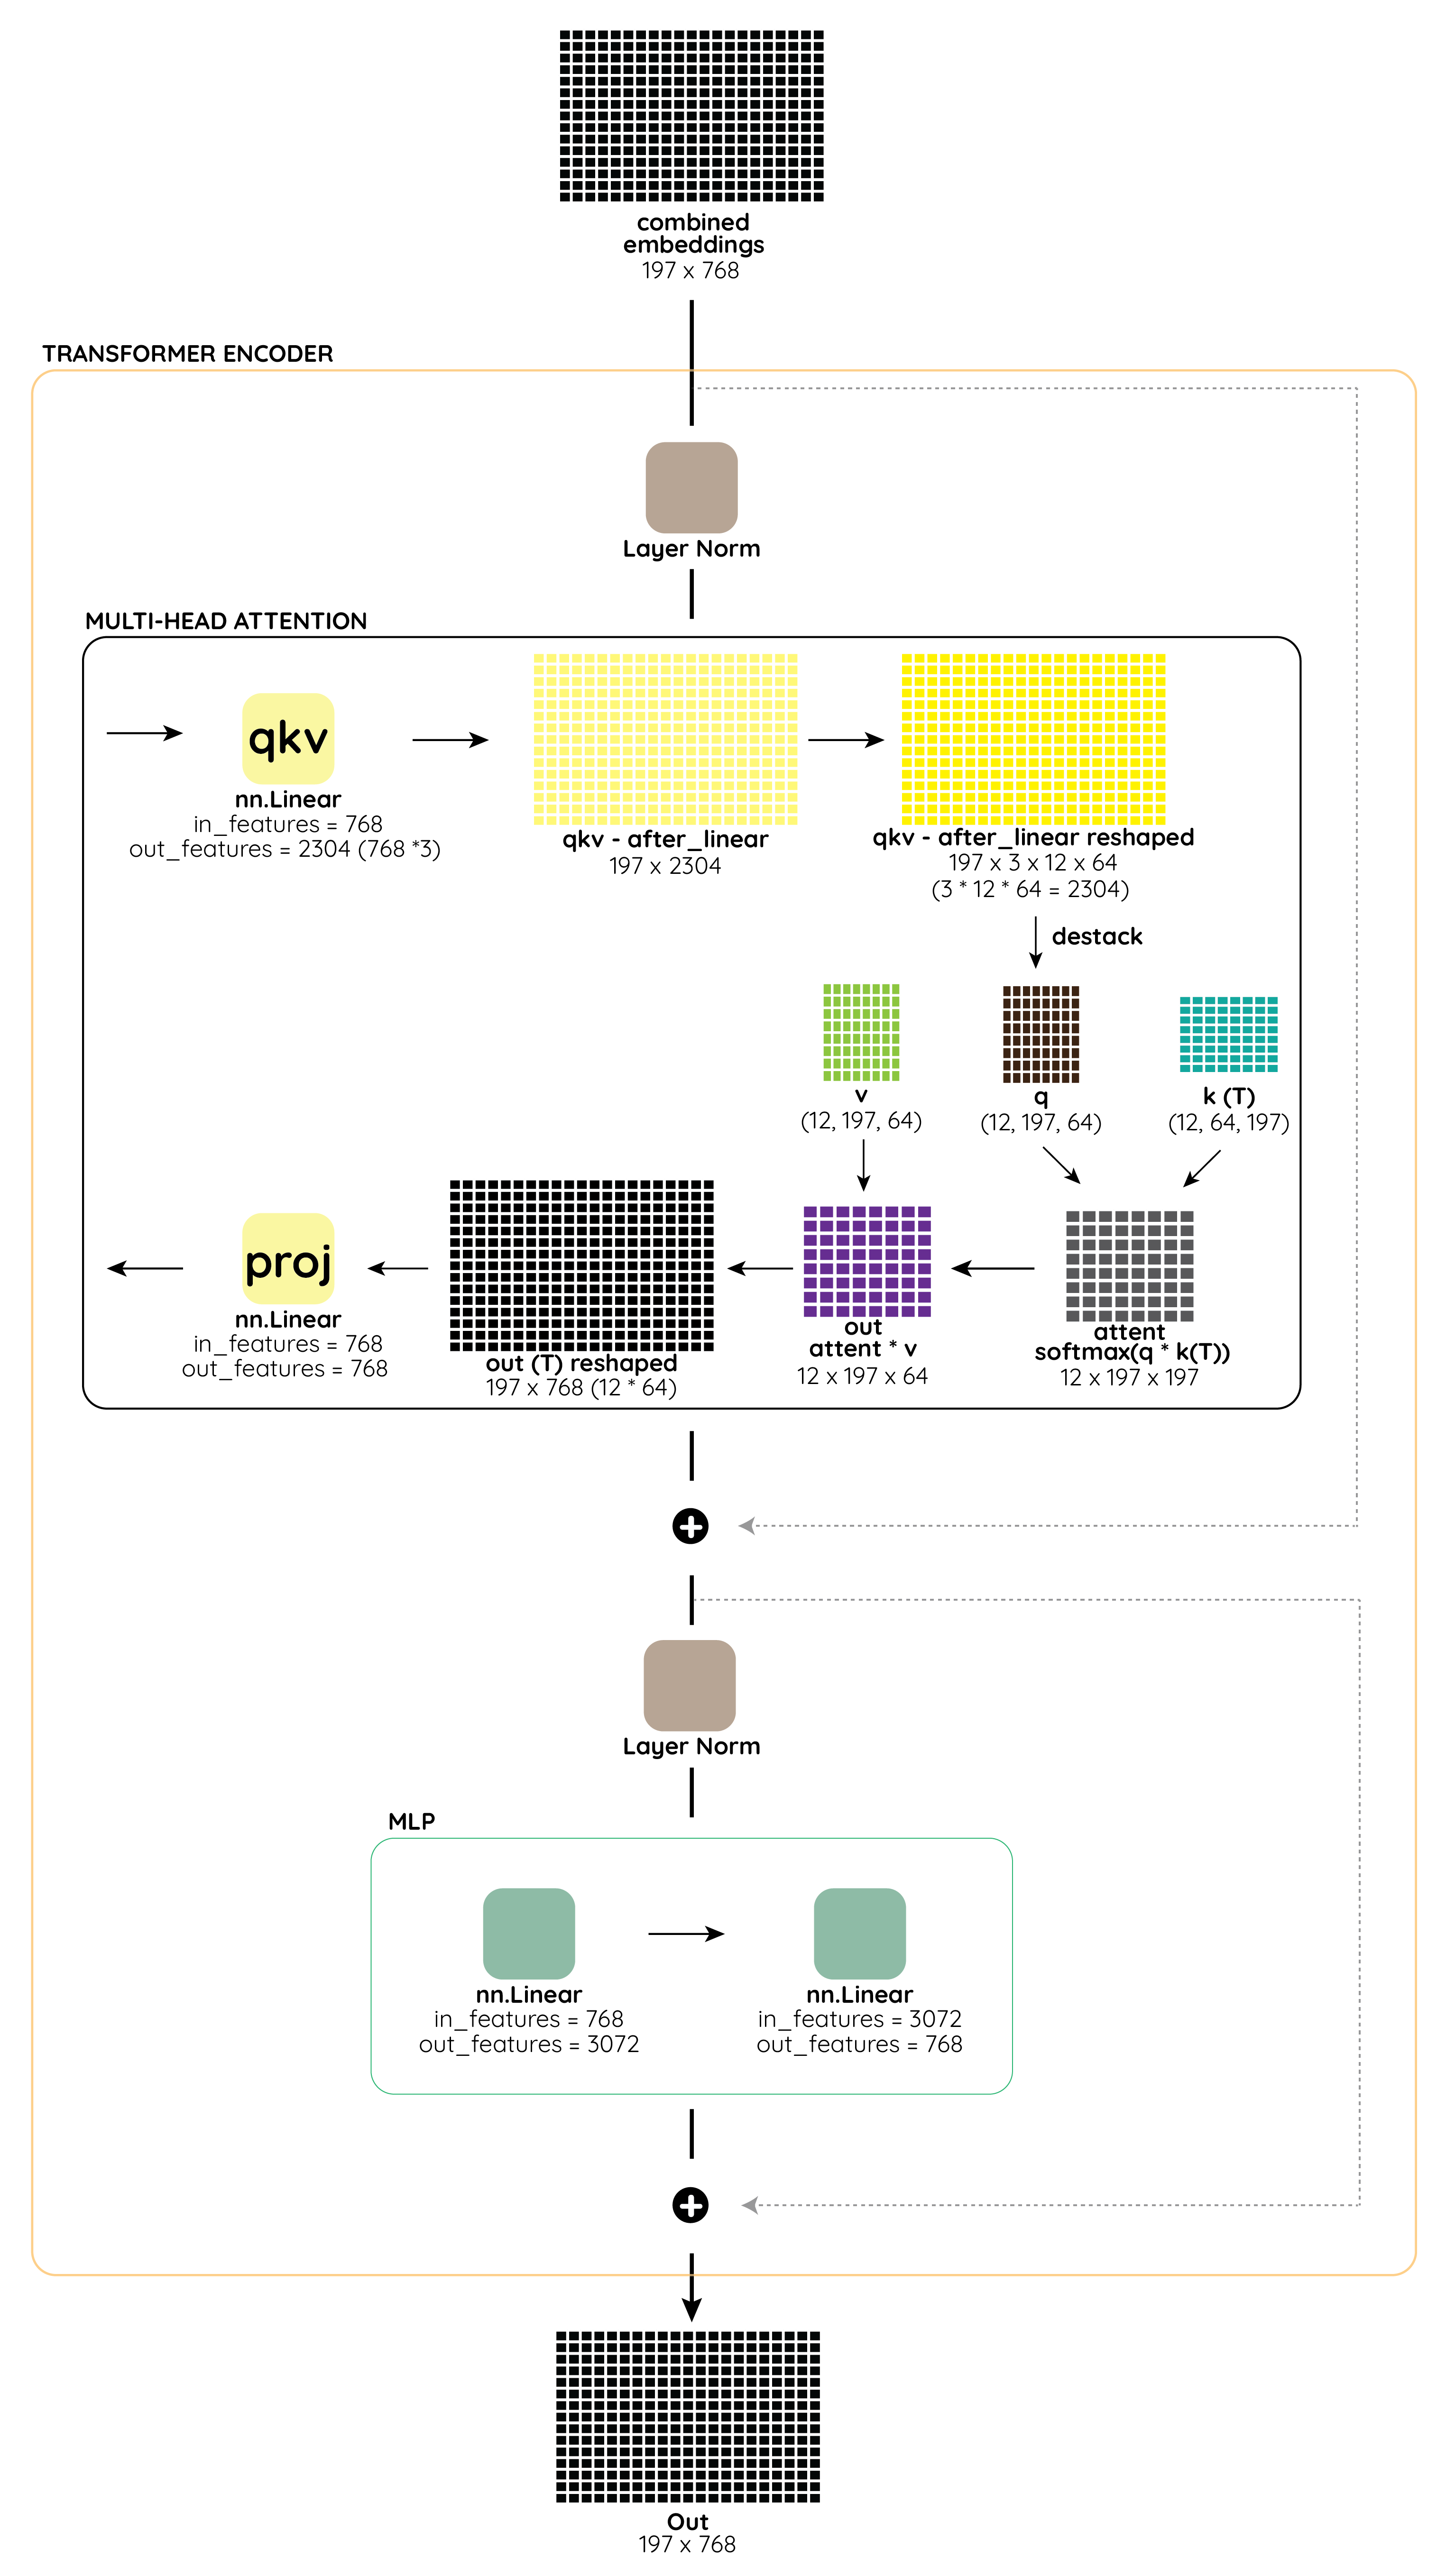

In [ ]:
disp_img('/content/vit-07.png')

### Combined embedding creation

In [11]:
def to_2tuple(x):
    if isinstance(x, collections.abc.Iterable):
       return x
    return x, x

In [12]:
class PatchEmbeddings(nn.Module):
     '''
     Image to patch embedding
     '''
     def __init__(self, image_size=224, patch_size=16, num_channels=3, embed_dim=768):
         super().__init__()
         image_size = to_2tuple(image_size)
         patch_size = to_2tuple(patch_size)
         num_patches = (image_size[1] // patch_size[1]) * (image_size[0] // patch_size[0])  # (224/16, 224/16) --> (14, 14)
         self.image_size = image_size
         self.patch_size = patch_size  
         self.num_patches = num_patches

         self.projection = nn.Conv2d(in_channels=num_channels, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)

     def forward(self, pixel_values):
         batch_size, num_channels, height, width = pixel_values.shape

         if height != self.image_size[0] or width != self.image_size[1]:\
             raise ValueError(
                f"Input image size ({height}*{width}) doesn't match model ({self.image_size[0]}*{self.image_size[1]})."
             )         
         x = self.projection(pixel_values).flatten(2).transpose(1, 2)   # Input to nn.Conv2d should be of format (batch_size, num_channels, height, width)
         return x

### Combined embedding creation is well represented via below image

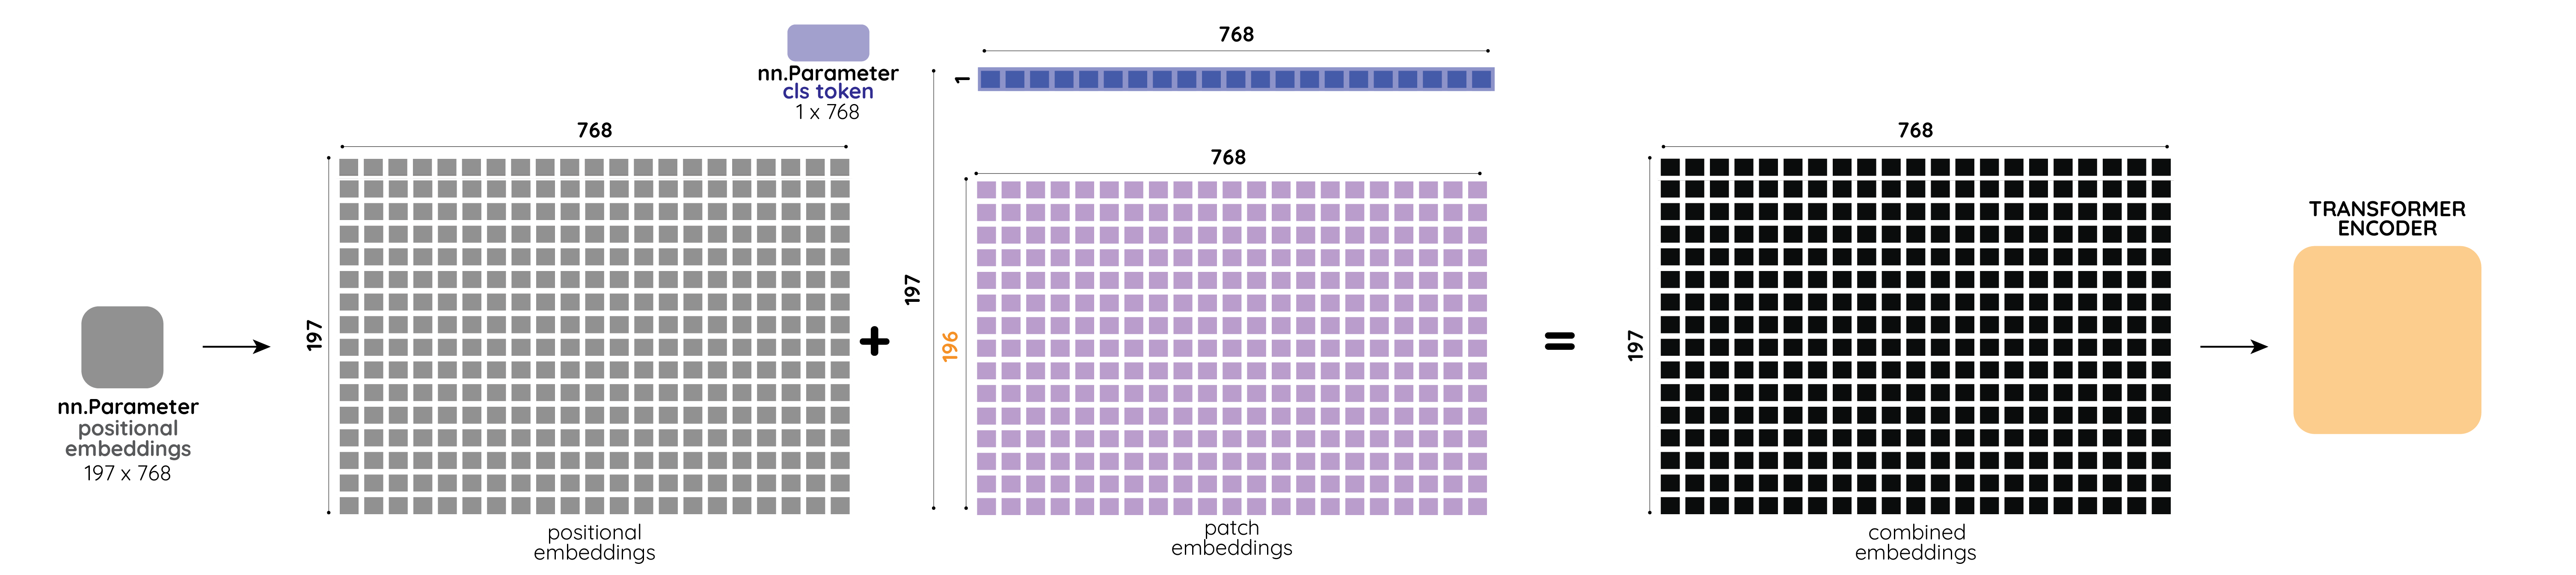

In [ ]:
disp_img('/content/vit-03.png')

In [13]:
class ViTEmbeddings(nn.Module):
     '''
     Construct the CLS token, position and patch embeddings.
     '''
     def __init__(self, config):
         super().__init__()

         self.cls_token = nn.Parameter(torch.zeros(1, 1, config.hidden_size))  # [1, 1, 768]
         self.patch_embeddings = PatchEmbeddings(
              image_size=config.image_size,
              patch_size=config.patch_size,
              num_channels=config.num_channels,
              embed_dim=config.hidden_size,
              )
         num_patches = self.patch_embeddings.num_patches                
         self.position_embeddings = nn.Parameter(torch.zeros(1, num_patches + 1, config.hidden_size)) # No need to expand pos embeddings to batch_size bcoz we will add it with patch_embeddings
         self.dropout = nn.Dropout(config.hidden_dropout_prob)

     def forward(self, pixel_values):
         batch_size = pixel_values.shape[0]
         embeddings = self.patch_embeddings(pixel_values)

         cls_tokens = self.cls_token.expand(batch_size, -1, -1)      # Expand to [32, 1, 768]
         embeddings = torch.cat((cls_tokens, embeddings), dim=1)
         embeddings = embeddings + self.position_embeddings
         embeddings = self.dropout(embeddings)
         return embeddings

In [14]:
class ViTConfig():
     def __init__(
         self,
         hidden_size=768,                     # (32, 3, 224, 224) -> Conv2d(3, 768, 16, 16) -> (32, 768, 14, 14) -> Flatten (32, 768, 196)
         num_hidden_layers=12,                # These are the layers in encoder
         num_attention_heads=12,              # This is for multi-head attention
         intermediate_size=3072,              # 768 * 4 (scaling_factor)
         hidden_act="gelu",
         hidden_dropout_prob=0.0,
         attention_probs_dropout_prob=0.0,
         initializer_range=0.02,
         layer_norm_eps=1e-12,
         is_encoder_decoder=False,
         image_size=224,
         patch_size=16,
         num_channels=3,
         **kwargs
     ):

         self.hidden_size = hidden_size     
         self.num_hidden_layers = num_hidden_layers
         self.num_attention_heads = num_attention_heads
         self.intermediate_size = intermediate_size
         self.hidden_act = hidden_act
         self.hidden_dropout_prob = hidden_dropout_prob
         self.attention_probs_dropout_prob = attention_probs_dropout_prob
         self.initializer_range = initializer_range
         self.layer_norm_eps = layer_norm_eps

         self.image_size = image_size
         self.patch_size = patch_size
         self.num_channels = num_channels

configuration = ViTConfig()
# You can read full configuration file here: https://github.com/huggingface/transformers/blob/master/src/transformers/models/vit/configuration_vit.py

In [15]:
vars(configuration)

{'attention_probs_dropout_prob': 0.0,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.0,
 'hidden_size': 768,
 'image_size': 224,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'layer_norm_eps': 1e-12,
 'num_attention_heads': 12,
 'num_channels': 3,
 'num_hidden_layers': 12,
 'patch_size': 16}

### **ViTSelfAttention()** deals with below logic - ie self attention

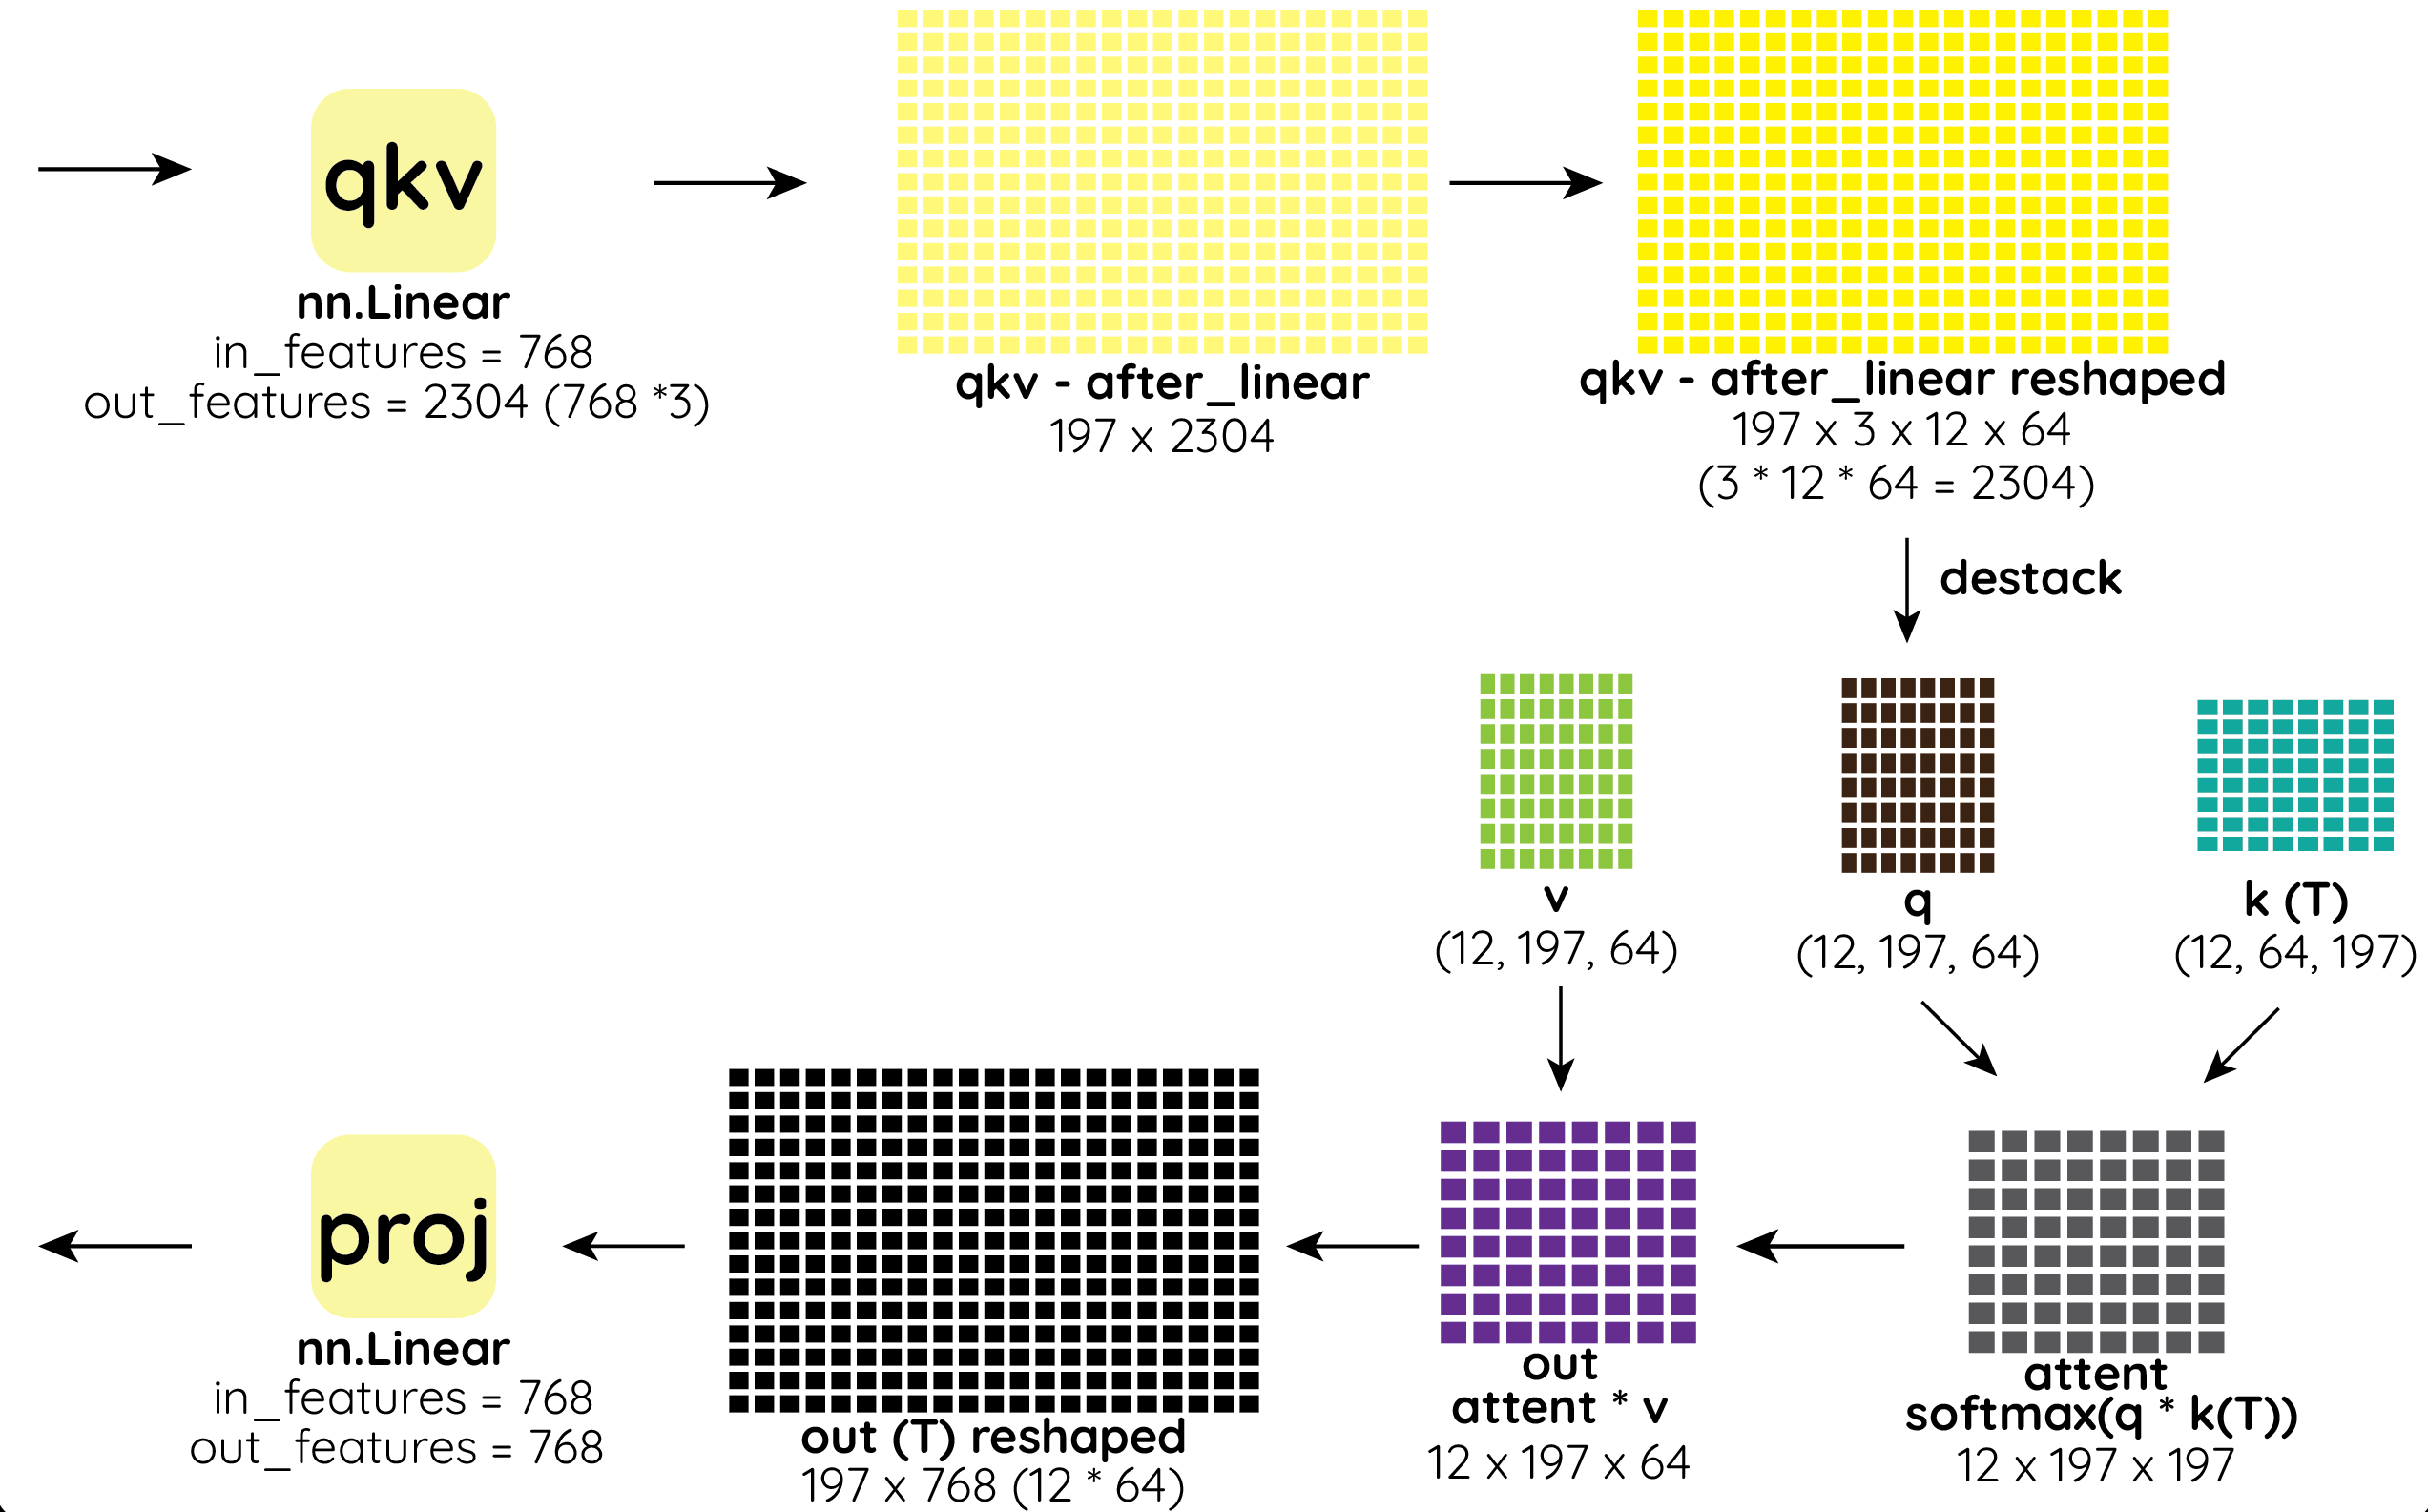

In [ ]:
disp_img('/content/Self_Attention.png')

In [16]:
import math
class ViTSelfAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        if config.hidden_size % config.num_attention_heads != 0 and not hasattr(config, "embedding_size"):
            raise ValueError(
                f"The hidden size {config.hidden_size,} is not a multiple of the number of attention "
                f"heads {config.num_attention_heads}."
            )

        self.num_attention_heads = config.num_attention_heads                               # 12
        self.attention_head_size = int(config.hidden_size / config.num_attention_heads)     # 768/12 = 64
        self.all_head_size = self.num_attention_heads * self.attention_head_size            # 12*64 = 768

        self.query = nn.Linear(config.hidden_size, self.all_head_size)                      # (768, 768) -> Query prep via FC layer
        self.key = nn.Linear(config.hidden_size, self.all_head_size)                        # (768, 768) -> Key prep via FC layer
        self.value = nn.Linear(config.hidden_size, self.all_head_size)                      # (768, 768) -> Value prep via FC layer

        self.dropout = nn.Dropout(config.attention_probs_dropout_prob)                      

    def transpose_for_scores(self, x):
        new_x_shape = x.size()[:-1] + (self.num_attention_heads, self.attention_head_size)  # (32, 197) + (12, 64) -> (32, 197, 12, 64)
        x = x.view(*new_x_shape)                                                            # (32, 197, 768) -> (32, 197, 12, 64)
        return x.permute(0, 2, 1, 3)                                                        # (32, 12, 197, 64)

    def forward(self, hidden_states, head_mask=None, output_attentions=True):
        mixed_query_layer = self.query(hidden_states)

        key_layer = self.transpose_for_scores(self.key(hidden_states))
        value_layer = self.transpose_for_scores(self.value(hidden_states))
        query_layer = self.transpose_for_scores(mixed_query_layer)

        # Take the dot product between "query" and "key" to get the raw attention scores.
        attention_scores = torch.matmul(query_layer, key_layer.transpose(-1, -2))  # Transposing key to enable matrix multiplication (32,12,197,64)*(32,12,64,197)->(32,12,197,197)

        attention_scores = attention_scores / math.sqrt(self.attention_head_size)  # Dividing to make the softmax operation more meaningful

        # Normalize the attention scores to probabilities.
        attention_probs = nn.Softmax(dim=-1)(attention_scores)                     # Softmax to keep the sum of values = 1

        # This is actually dropping out entire tokens to attend to, which might
        # seem a bit unusual, but is taken from the original Transformer paper.
        attention_probs = self.dropout(attention_probs)                            # (32, 12, 197, 197)

        # Mask heads if we want to
        if head_mask is not None:
            attention_probs = attention_probs * head_mask

        context_layer = torch.matmul(attention_probs, value_layer)                # Multiplying attention vector with original embedding transformed via FC(value_layer)

        context_layer = context_layer.permute(0, 2, 1, 3).contiguous()            # (32, 12, 197, 64) -> (32, 197, 12, 64) 
        new_context_layer_shape = context_layer.size()[:-2] + (self.all_head_size,)      # (32, 197) + (768,) -> (32, 197, 768)
        context_layer = context_layer.view(*new_context_layer_shape)              # Reshaping back to (32, 197, 768)

        outputs = (context_layer, attention_probs) if output_attentions else (context_layer,)
                   #(32,197,768)  #(32,12,197,197) , outputs is a tuple
        return outputs

In [17]:
vit_atn = ViTSelfAttention(configuration)
vit_atn

ViTSelfAttention(
  (query): Linear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [18]:
class ViTSelfOutput(nn.Module):
     """
     This is just a Linear Layer Block
     """
     def __init__(self, config):
         super().__init__()
         self.dense = nn.Linear(config.hidden_size, config.hidden_size)
         self.dropout = nn.Dropout(config.hidden_dropout_prob)

     def forward(self, hidden_states, input_tensor):
         hidden_states = self.dense(hidden_states)
         hidden_states = self.dropout(hidden_states)

         return hidden_states

In [19]:
class ViTAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = ViTSelfAttention(config)
        self.output = ViTSelfOutput(config)
        self.pruned_heads = set()

    # WE ARE NOT USING PRUNE_HEADS IN THIS NOTEBOOK
    def prune_heads(self, heads):
        if len(heads) == 0:
            return
        heads, index = find_pruneable_heads_and_indices(
            heads, self.attention.num_attention_heads, self.attention.attention_head_size, self.pruned_heads
        )

        # Prune linear layers
        self.attention.query = prune_linear_layer(self.attention.query, index)
        self.attention.key = prune_linear_layer(self.attention.key, index)
        self.attention.value = prune_linear_layer(self.attention.value, index)
        self.output.dense = prune_linear_layer(self.output.dense, index, dim=1)

        # Update hyper params and store pruned heads
        self.attention.num_attention_heads = self.attention.num_attention_heads - len(heads)
        self.attention.all_head_size = self.attention.attention_head_size * self.attention.num_attention_heads
        self.pruned_heads = self.pruned_heads.union(heads)

    def forward(self, hidden_states, head_mask=None, output_attentions=True):
        self_outputs = self.attention(hidden_states, head_mask, output_attentions)
        attention_output = self.output(self_outputs[0], hidden_states)
        outputs = (attention_output,) + self_outputs[1:]  # Include attentions also in outputs if we want to output them 
                                                          # outputs is a tuple -> ( [32, 197, 768] , [32, 12, 197, 197] )
        return outputs

### MLP Blocks - **ViTIntermediate() & ViTOutput()**

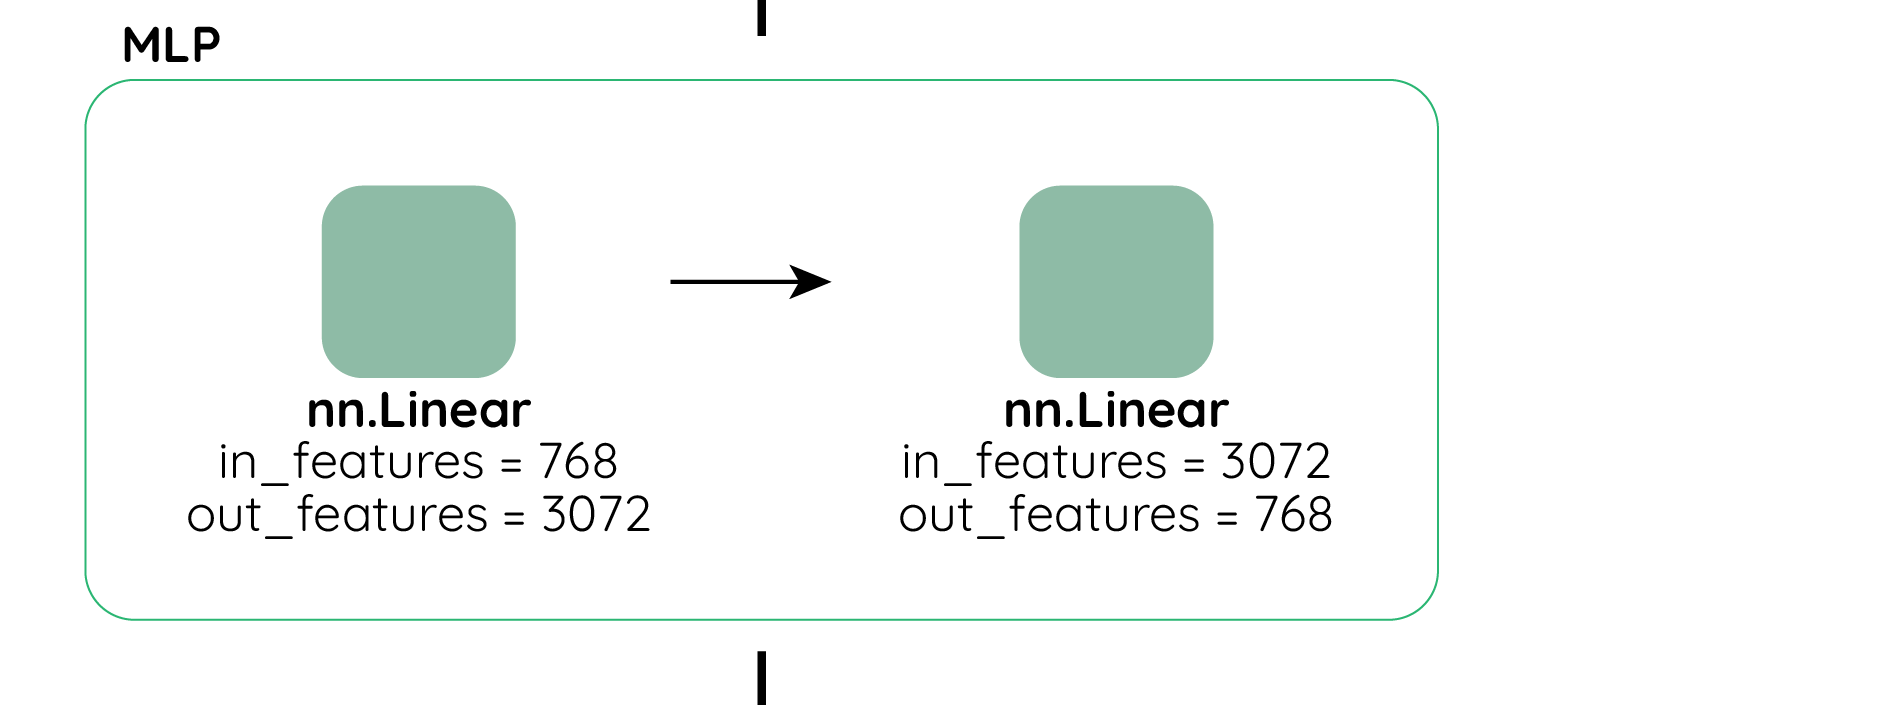

In [ ]:
disp_img('/content/MLP.png')

In [20]:
# Scaling up by 4 from 768 to 3072

class ViTIntermediate(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.intermediate_size)

    def forward(self, hidden_states):

        hidden_states = self.dense(hidden_states)
        hidden_states = nn.functional.gelu(hidden_states)

        return hidden_states

In [21]:
# Scaling back from from 3072 to 768

class ViTOutput(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.intermediate_size, config.hidden_size)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, hidden_states, input_tensor):
        hidden_states = self.dense(hidden_states)
        hidden_states = self.dropout(hidden_states)

        hidden_states = hidden_states + input_tensor

        return hidden_states

### **ViTLayer()** that brings below flow to action

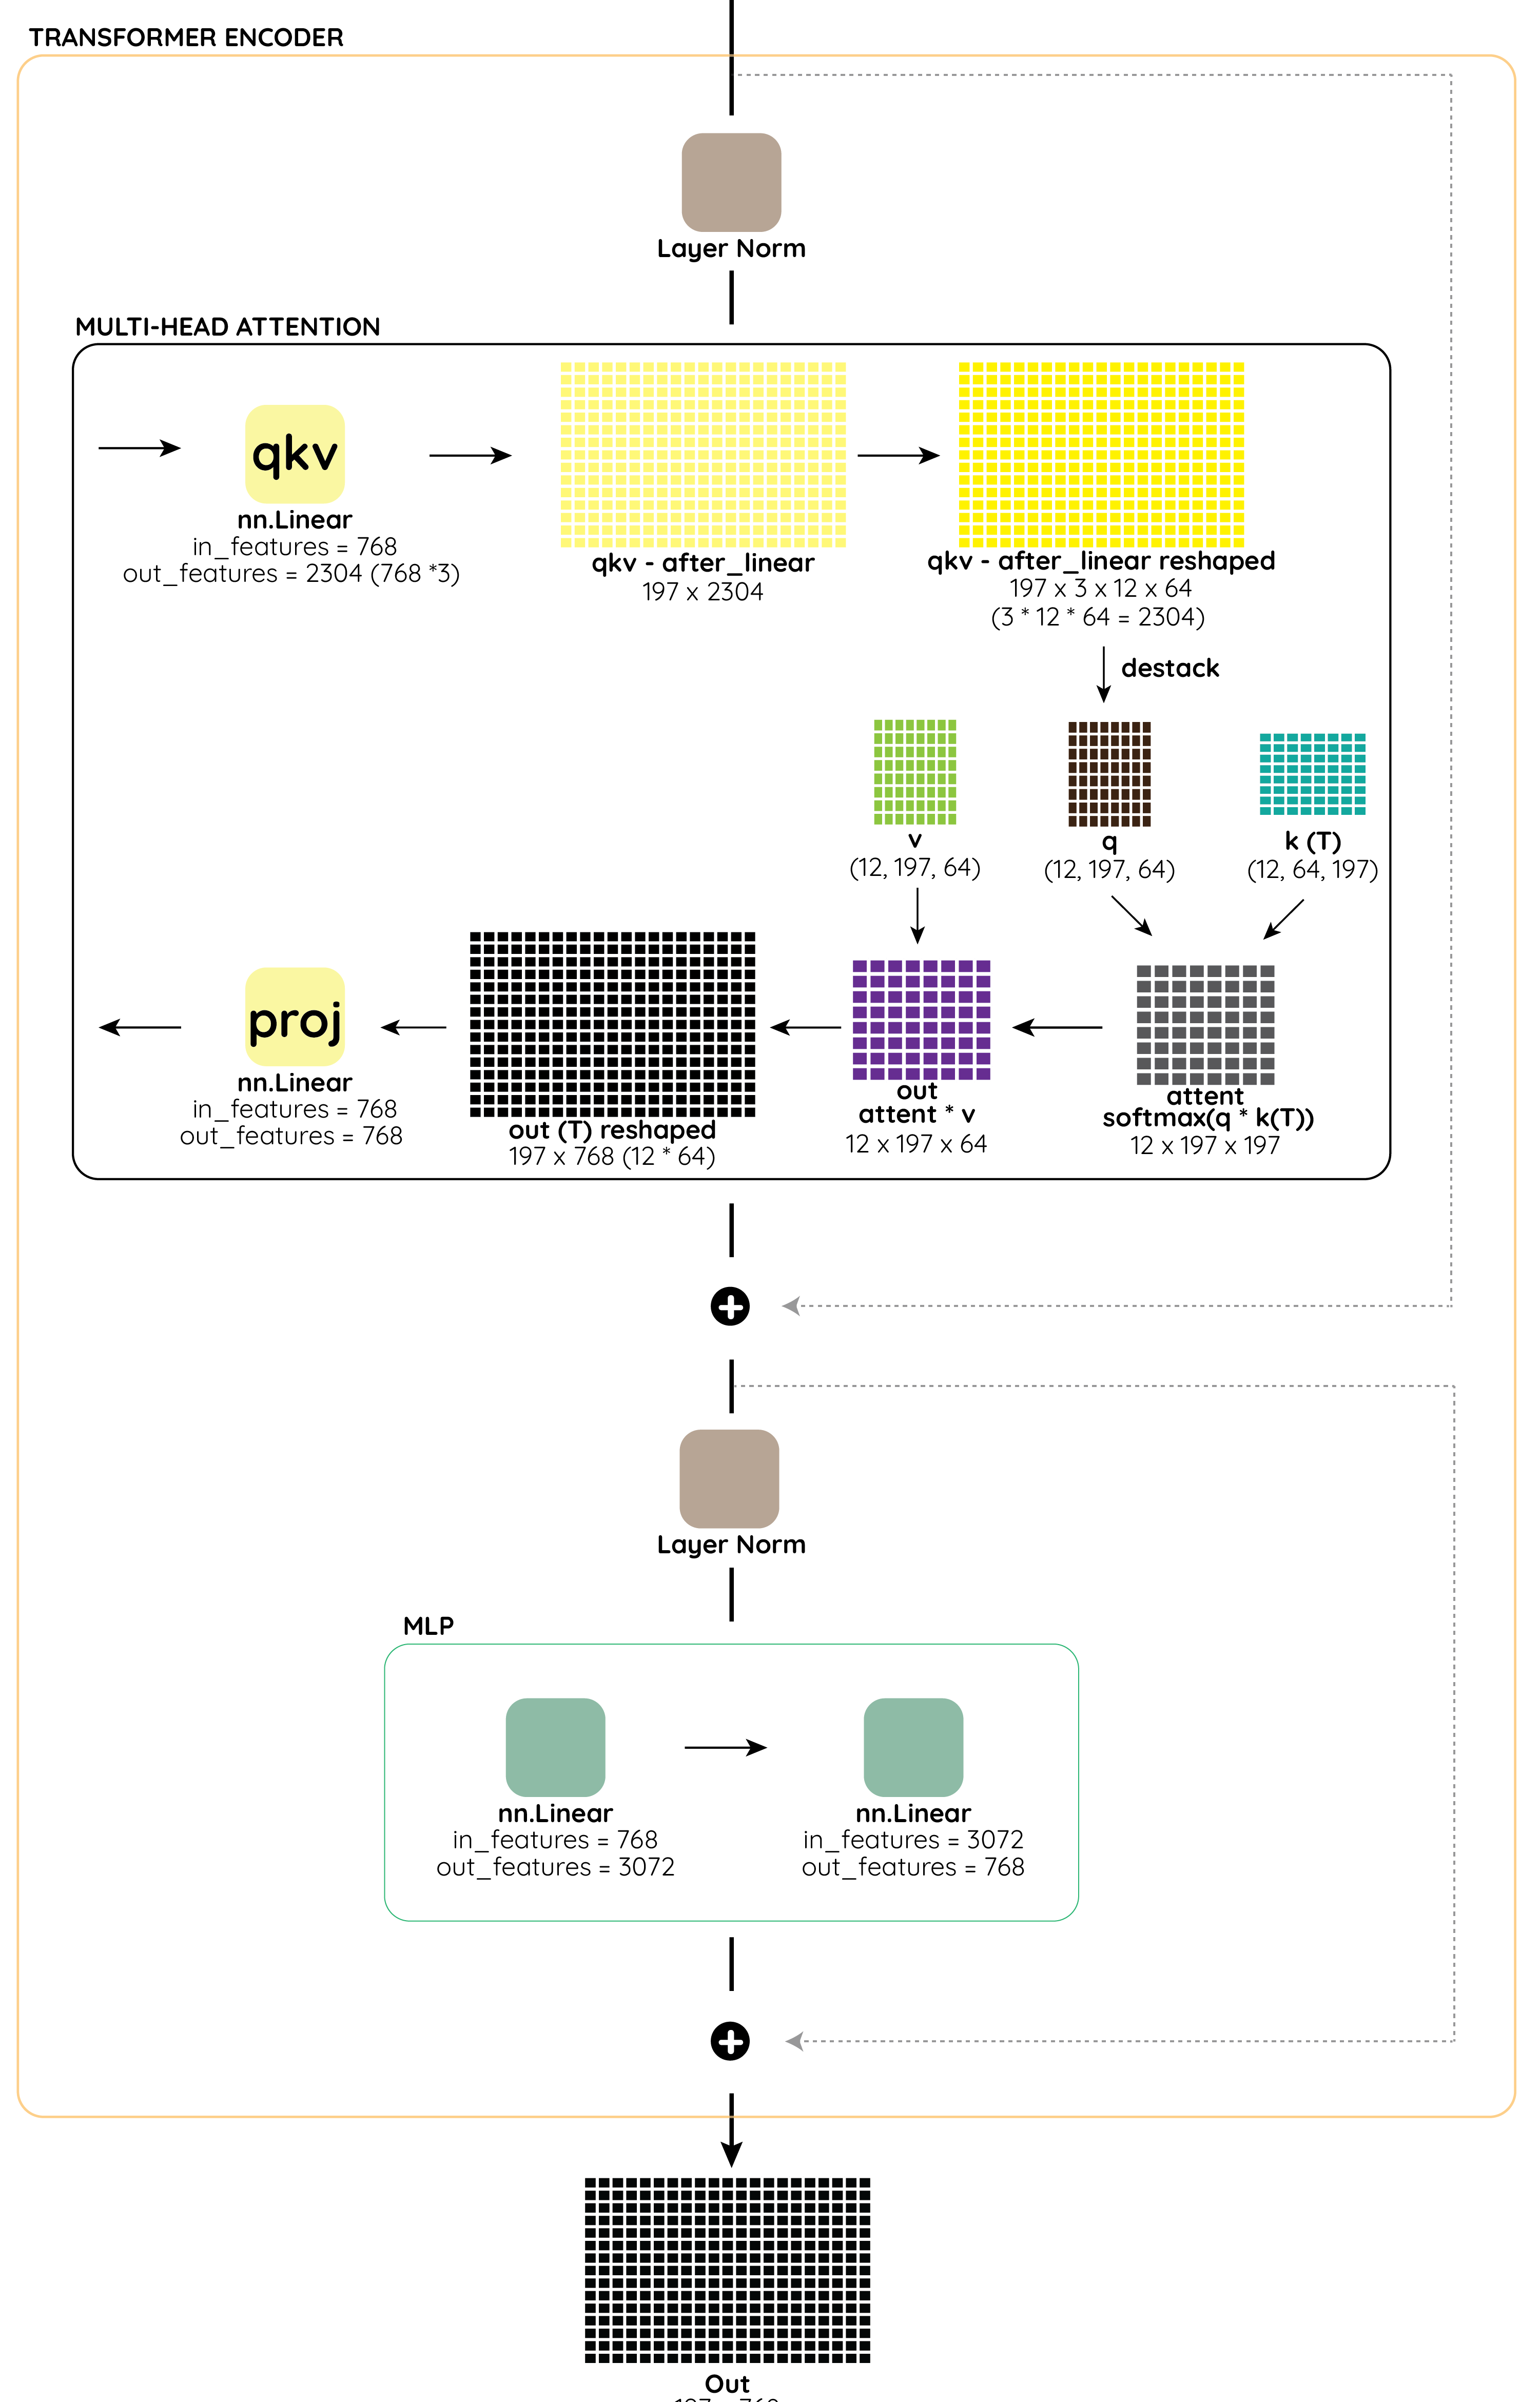

In [ ]:
disp_img('/content/ViTLayer.png')

In [22]:
class ViTLayer(nn.Module):
    """This corresponds to the Block class in the timm implementation."""

    def __init__(self, config):
        super().__init__()
        self.seq_len_dim = 1
        self.attention = ViTAttention(config)
        self.intermediate = ViTIntermediate(config)
        self.output = ViTOutput(config)
        self.layernorm_before = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)
        self.layernorm_after = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, hidden_states, head_mask=None, output_attentions=True):
        self_attention_outputs = self.attention(
            self.layernorm_before(hidden_states),  # in ViT, layernorm is applied before self-attention
            head_mask,
            output_attentions=output_attentions,
        )
        attention_output = self_attention_outputs[0]
        outputs = self_attention_outputs[1:]  # add self attentions if we output attention weights
        # first residual connection
        hidden_states = attention_output + hidden_states

        # in ViT, layernorm is also applied after self-attention
        layer_output = self.layernorm_after(hidden_states)

        layer_output = self.intermediate(layer_output)

        # second residual connection is done here
        layer_output = self.output(layer_output, hidden_states)   #[32, 197, 768]

        outputs = (layer_output,) + outputs                       # Please note that we are doing tuple addition here & NOT tensor addition                              
        return outputs

    # No NEED to bother at this point on below
    def feed_forward_chunk(self, attention_output):
        intermediate_output = self.intermediate(attention_output)
        layer_output = self.output(intermediate_output)
        return layer_output

In [23]:
# Encoder runs 12 times as we gave num_hidden_layers = 12 in configuration. Will execute the attention layer 10 times

class ViTEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.layer = nn.ModuleList([ViTLayer(config) for _ in range(config.num_hidden_layers)])

    def forward(
        self,
        hidden_states,
        head_mask=None,
        output_attentions=True,
        output_hidden_states=False,
        return_dict=True,
    ):
        all_hidden_states = () if output_hidden_states else None
        all_self_attentions = () if output_attentions else None

        for i, layer_module in enumerate(self.layer):
            if output_hidden_states:
                all_hidden_states = all_hidden_states + (hidden_states,)

            layer_head_mask = head_mask[i] if head_mask is not None else None

            if getattr(self.config, "gradient_checkpointing", False) and self.training:

                def create_custom_forward(module):
                    def custom_forward(*inputs):
                        return module(*inputs, output_attentions)

                    return custom_forward

                layer_outputs = torch.utils.checkpoint.checkpoint(
                    create_custom_forward(layer_module),
                    hidden_states,
                    layer_head_mask,
                )
            else:
                layer_outputs = layer_module(hidden_states, layer_head_mask, output_attentions)

            hidden_states = layer_outputs[0]

            if output_attentions:
                all_self_attentions = all_self_attentions + (layer_outputs[1],)

        if output_hidden_states:
            all_hidden_states = all_hidden_states + (hidden_states,)

        if not return_dict:
            return tuple(v for v in [hidden_states, all_hidden_states, all_self_attentions] if v is not None)
        
        return hidden_states,all_hidden_states,all_self_attentions


### **ViTPooler** that passes only [CLS] token to Final FC layer for classification. 

In [24]:
class ViTPooler(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.Tanh()

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding
        # to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.activation(pooled_output)
        return pooled_output

### **ViTModel()** where everything comes together !

In [25]:
class ViTModel(nn.Module):
    def __init__(self, configuration, add_pooling_layer=True):
        super().__init__()
        self.config = configuration

        self.embeddings = ViTEmbeddings(configuration)
        self.encoder = ViTEncoder(configuration)

        self.layernorm = nn.LayerNorm(configuration.hidden_size, eps=configuration.layer_norm_eps)
        self.pooler = ViTPooler(configuration) if add_pooling_layer else None
        self.classifier = nn.Linear(configuration.hidden_size, 2) 

    def get_input_embeddings(self):
        return self.embeddings.patch_embeddings

    def forward(self, pixel_values=None,
                      head_mask=None,
                      output_attentions=None,
                      output_hidden_states=None,
                      return_dict=None,):

        if pixel_values is None:
            raise ValueError("You have to specify pixel_values")

        embedding_output = self.embeddings(pixel_values)

        encoder_outputs = self.encoder(
            embedding_output,
            head_mask=head_mask,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        sequence_output = encoder_outputs[0]
        sequence_output = self.layernorm(sequence_output)
        pooled_output = self.pooler(sequence_output) if self.pooler is not None else None
        final_output = self.classifier(pooled_output)

        return final_output

In [26]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


In [27]:
model = ViTModel(configuration).to(device)

In [28]:
batch_size = 32
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)

In [29]:
epochs = 10
lr = 3e-5
gamma = 0.7 #for learning rate scheduler 
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output = model(data)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output = model(data)
            val_loss = criterion(val_output, label)
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)
    print(
        f"Epoch: {epoch+1} -Train loss: {epoch_loss:.4f} - Train acc: {epoch_accuracy:.4f} - val_loss: {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


Epoch: 1 -Train loss: 0.6835 - Train acc: 0.5561 - val_loss: 0.6649 - val_acc: 0.6318




Epoch: 2 -Train loss: 0.6258 - Train acc: 0.6451 - val_loss: 0.5996 - val_acc: 0.6678




Epoch: 3 -Train loss: 0.5956 - Train acc: 0.6767 - val_loss: 0.5962 - val_acc: 0.6827




Epoch: 4 -Train loss: 0.5811 - Train acc: 0.6909 - val_loss: 0.5704 - val_acc: 0.7028




Epoch: 5 -Train loss: 0.5676 - Train acc: 0.7053 - val_loss: 0.5632 - val_acc: 0.7082




Epoch: 6 -Train loss: 0.5571 - Train acc: 0.7098 - val_loss: 0.5437 - val_acc: 0.7275




Epoch: 7 -Train loss: 0.5547 - Train acc: 0.7144 - val_loss: 0.5452 - val_acc: 0.7251




Epoch: 8 -Train loss: 0.5481 - Train acc: 0.7202 - val_loss: 0.5606 - val_acc: 0.7114

